In [1]:
import simpy
import numpy as np
import functools
import matplotlib.pyplot as plt
from Stats import Entity, Resource, Source

## Things that Changed: 

1. Got rid of `__init__(*args, **kwargs)` in constructors for all classes
2. Hid the gross "process" function in the `Source` class. Now to start simulation you call source.start(resources)
3. Passing resources to entity.process as a dictionary of resources. This was necessary for hiding the gross process function from #2 above.
4. All resources are now priority resources. Students can define a priority as a static `priority` variable in an entity class, or they can define a priority attribute for the entity on construction. If no priority is defined in either of those places, a default priority of 0 is used.
5. No longer need to define a unique name when constructing entities. Entities are named `{EntityClassName} {counter}` by default, where counter starts at 1 and increments for every entity produced by the source. So for the examples below, entities will be named `Customer 1` `Customer 2` by default.
6. Entities now no longer need kwargs to define their attributes on construction. They now accept an "attributes" dictionary. If no attributes dictionary is provided, an empty dictionary will be supplied automatically.
7. You can pass a resource to the `source.get_waiting_times()` and `source.get_processing_times` functions to get the waiting / processing times for each entity at that resource. If the entity did not visit that resource, the resulting array will contain a `None` value for that entity.
8. You now need to remember to call self.dispose() at the end of the entity's process function.

## Description of problem: 

We are going to model a restaurant.

Customers can be either take out or dine in customers

Take out customers will have higher priority, since they are in a hurry.

Customers start by ordering, which is passed to the kitchen.
The Kitchen is described as follows: 
 - 2 cooks
 - 3 things to order:
   - fish -- 15 mins to prepare
   - burger -- 5 mins to prepare
   - salad -- 8 mins to prepare
   
Then must wait for a seat
- people will sit for between 20-30 minutes. 
- Capacity: 4
- Assume all attendees are dining alone (no need to worry about specific party capacity, or matching to tables).


In [12]:
# Our Kitchen class subclasses PriorityResource. We give it a unique name of "kitchen"
class Kitchen(Resource):
    def next_service_time(self, entity):
        """
        Defines preparation time for each dish
        Since we can pass the entity being processed to next_service_time when we call it, 
        we can react to the requirements of the entity (e.g. fish takes longer to prepare)
        """
        if entity.attributes["food"] == "Fish":
            return 100
        elif entity.attributes["food"] == "Burger":
            return 5
        elif entity.attributes["food"] == "Salad":
            return 8
        else:
            raise Exception("Restaurant does not serve this kind of food")
        

# Our DiningRoom class subclasses Resource. We give it a unique name of "DiningRoom"
class DiningRoom(Resource):
    def next_service_time(self, entity):
        """
        random integer of time between 20 and 30 minutes per problem specification
        """
        return np.random.randint(20, 30) # 20 to 30 minute seating per entity



In [13]:
# entities are in charge of the order in which interactions with resources occur
class DineInCustomer(Entity):
    
    priority = 1
    
    # template method for all of the resources it needs to interact with
    def process(self, kitchen, dining_room):
        
        # interface with kitchen
        request = self.request_resource(kitchen)
        yield request
        
        self.start_service_at_resource(kitchen)
        cook_time = kitchen.next_service_time(self) # next_service_time is defined in kitchen
        yield self.env.timeout(cook_time)
        
        self.release_resource(kitchen, request)
        
        # interface with dining_room
        request = self.request_resource(dining_room)
        yield request
        
        self.start_service_at_resource(dining_room)
        seat_time = dining_room.next_service_time(self) # next_service_time is defined in dining_room
        yield self.env.timeout(seat_time)
        
        self.release_resource(dining_room, request)

class TakeOutCustomer(Entity):
    
    priority = 0
    
    # template method for all of the resources it needs to interact with
    def process(self, kitchen, dining_room):
        
        # interface with kitchen
        request = self.request_resource(kitchen)
        yield request
        
        self.start_service_at_resource(kitchen)
        cook_time = kitchen.next_service_time(self) # next_service_time is defined in kitchen
        yield self.env.timeout(cook_time)
        
        self.release_resource(kitchen, request)
        
        # take out does not need to go to the dining room

In [14]:
# The source is what contains the interarrival time definition, and rules for constructing entities 
# with various attribute sets.
class CustomerSource(Source):
    def interarrival_time_generator(self):
        while True:
            yield np.random.choice([1,10,15,20], p=[0.5, 0.2, 0.2, 0.1])
    
    def sample_from_foods(self):
        return np.random.choice(["Fish", "Burger", "Salad"], p=[0.1,0.7,0.2])
    
    def is_dine_in(self):
        # returns true if the customer is dine in with a 65% likelihood
        return np.random.random() > 0.50
    
    def build_entity(self):
        attributes = {
            "food": self.sample_from_foods()
        }
        if self.is_dine_in():
            return DineInCustomer(env, attributes)
         
        return TakeOutCustomer(env, attributes)

In [15]:
def process(env, customer_source, kitchen, dining_room):
    """ Generate arrivals into our simulation
    
    Arguments:   
     env:  Our simulation environment
     source: the source of entities for our simulation
     resource: Shared resource
    """
    
    def dispose(entity):
        return lambda _: entity.dispose()
    
    # consider turning customer_source into an iterator to call next on it.
    for arrival_time, customer in customer_source.next_entity(): 
        yield arrival_time # wait for the next entity to appear
        print(f"{customer}")
        processed_entity = env.process(customer.process(kitchen, dining_room))
        processed_entity.callbacks.append(dispose(customer))


In [16]:
# Create simulation environment
env = simpy.Environment()

# Configure source to generate fixed number of entities
source = CustomerSource(env, number=10)

# Configure DiningRoom to have space for 4 diners
dining_room = DiningRoom(env,  capacity=4)

# Configure Kitchen to have 2 chefs
kitchen = Kitchen(env, capacity=2)

# Aside: if students want to tune various parameters of the simulation, they could configure each component
#        of the simulation here, then loop over the construction of each with different combinations of parameters

In [17]:
env.process(process(env, source, kitchen, dining_room))
env.run()

TakeOutCustomer 1 created_at: 15 attributes: {'food': 'Salad', 'priority': 0}
TakeOutCustomer 1 requesting Kitchen: 15
TakeOutCustomer 1 started processing at Kitchen : 15
TakeOutCustomer 1 finished at Kitchen: 23
TakeOutCustomer 1 disposed: 23
DineInCustomer 2 created_at: 25 attributes: {'food': 'Fish', 'priority': 1}
DineInCustomer 2 requesting Kitchen: 25
DineInCustomer 2 started processing at Kitchen : 25
TakeOutCustomer 3 created_at: 26 attributes: {'food': 'Burger', 'priority': 0}
TakeOutCustomer 3 requesting Kitchen: 26
TakeOutCustomer 3 started processing at Kitchen : 26
TakeOutCustomer 3 finished at Kitchen: 31
TakeOutCustomer 3 disposed: 31
DineInCustomer 4 created_at: 41 attributes: {'food': 'Burger', 'priority': 1}
DineInCustomer 4 requesting Kitchen: 41
DineInCustomer 4 started processing at Kitchen : 41
DineInCustomer 5 created_at: 42 attributes: {'food': 'Salad', 'priority': 1}
DineInCustomer 5 requesting Kitchen: 42
DineInCustomer 6 created_at: 43 attributes: {'food': '

## Step 7: Extract Summary Statistics from Source / Resource

Source provides methods that calculate summary statistics about the entities while they were in the system. 

Resource provides methods to see what the queue was like at each resource over time.

See the following code blocks for some plots and calculations made with the summary stats.

In [21]:
system_time = source.get_total_times()
print("total_time:", source.get_total_times())
print("waiting_time:", source.get_waiting_times())
print("processing_time:", source.get_processing_times())

print(int(env.now))

queue_over_time_kitchen = kitchen.queue_size_over_time() # sample queue length
print(queue_over_time_kitchen)


queue_over_time_dining_room = dining_room.queue_size_over_time() # sample queue length
print(queue_over_time_dining_room)

print("waiting time at kitchen", source.get_waiting_times(kitchen))
print("processing time at kitchen", source.get_processing_times(kitchen))

print("waiting time at dining_room", source.get_waiting_times(dining_room))
print("processing time at dining_room", source.get_processing_times(dining_room))

total_time: [8, 125, 5, 25, 43, 46, 7, 53, 60, 49]
waiting_time: [0, 0, 0, 0, 9, 16, 2, 19, 23, 19]
processing_time: [8, 125, 5, 25, 34, 30, 5, 34, 37, 30]
150
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

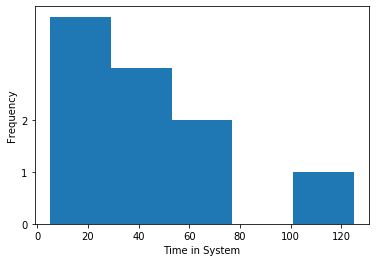

In [22]:
plt.hist(system_time,bins=5)
# you can customize the exact tick marks on an axis
plt.yticks(range(0,3))
plt.ylabel('Frequency');
plt.xlabel('Time in System');

Average number in queue: 0.5666666666666667
Max in queue: 4


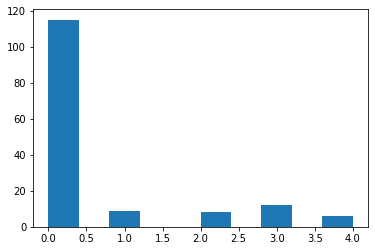

In [23]:
"""
Histogram of queue over time
"""
plt.hist(queue_over_time_kitchen)
print(f"Average number in queue: {np.mean(queue_over_time_kitchen)}")
print(f"Max in queue: {np.max(queue_over_time_kitchen)}")

Average number in queue: 0.02
Max in queue: 1


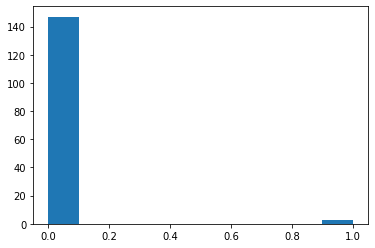

In [24]:
plt.hist(queue_over_time_dining_room)
print(f"Average number in queue: {np.mean(queue_over_time_dining_room)}")
print(f"Max in queue: {np.max(queue_over_time_dining_room)}")

In [25]:
print(f"max system time {np.max(system_time)}")
# 50th percentile, or median
print(f"50th percentile time {np.percentile(system_time,50)}")
print(f"std system time {np.std(system_time)}")

max system time 125
50th percentile time 44.5
std system time 33.82144290239552


## What next? 

Adjust capacities at each resource and see how the summary statistics change.
- how many chefs do you need in the kitchen to ensure 0 wait times with the current interarrival function? 
- What if we expanded our dining room... How big would we need to make the average wait time for a seat to be under 10 minutes? 

Could also adjust interarrival times / resource service times to see how that impacts
- What if we retrained chefs to cook fish 5 seconds faster... would that impact wait times? 
- What if we get a huge rush at night and interarrival time spikes to 1 minute. How bad would wait times get? 
- How to implement reneging customers? 